In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.python.keras.datasets import cifar100
from tensorflow.python.keras.utils import to_categorical

import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
from CNN import ThreeLayerConvNet
from model import myModel
from keras.models import Model
 
import timeit, time, pickle, h5py, os, math, copy

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
tf.logging.set_verbosity(tf.logging.ERROR)

In [6]:
def analize_size_for_ensembling(data_set, data_set_logits, test_acc, cls ):
    dataset_size= data_set.shape[0]
    ensemble_acc = []
    best_model_acc = []
    class_ensemb_better =[]
    class_best_model_better =[]
    best_net = np.argmax(test_acc)
    for i in range(len(data_set_logits)):
        i=i+1
        print(('Ensembled models: {0}').format(i))
        #best net of the ensemble models
        print(('Best model of models: {0}').format(best_net))
        ensemble_pred_labels = np.mean(data_set_logits[i], axis=0)
        ensemble_cls_pred = np.argmax(ensemble_pred_labels, axis=1)
        ensemble_correct = (ensemble_cls_pred == cls.T)
        #compute ensemble models accuracy:
        ensb_acc = np.sum(ensemble_correct)/dataset_size
        ensemble_acc.append(ensb_acc) 
        print(('Ensembled models accuracy: {0}').format(ensb_acc))
        ensemble_incorrect = np.logical_not(ensemble_correct)
        
        #compute best model's accuracy:
        best_net_pred_labels = data_set_logits[i][best_net, :, :]
        best_net_cls_pred = np.argmax(best_net_pred_labels, axis=1)
        best_net_correct = (best_net_cls_pred == cls.T)
        best_model_acc_ = np.sum(best_net_correct)/dataset_size
        best_model_acc.append(best_model_acc_)
        print(('Single best model accuracy: {0}').format(best_model_acc_))
        best_net_incorrect = np.logical_not(best_net_correct)

        #ensemble better than best model:
        ensemble_better = np.logical_and(best_net_incorrect,
                                         ensemble_correct)
        ensb_better = ensemble_better.sum()/best_net_incorrect.sum()
        class_ensemb_better.append(ensb_better)
        print(('Better classified by ensembled and not by best model: {0}%').format(ensb_better * 100))
        #best model better than ensemble:
        best_net_better = np.logical_and(best_net_correct,
                                         ensemble_incorrect)
        bm_better =best_net_better.sum()/ensemble_incorrect.sum()
        class_best_model_better.append(bm_better)
        print(('Better classified by best model and not by ensemble model: {0}%').format(bm_better*100))
    
    return ensemble_acc, class_ensemb_better, class_best_model_better, best_model_acc


In [9]:
def random_training_set():
    # Create a randomized index into the full / combined training-set.
    idx = np.random.permutation(images_train.shape[0])

    # Split the random index into training- and validation-sets.
    idx_train = idx[0:train_size]
    idx_validation = idx[train_size:]

    # Select the images and labels for the new training-set.
    x_train = images_train[idx_train, :]
    y_train = labels_train[idx_train, :]

    return x_train, y_train

def random_batch(x_train, y_train):
    # Total number of images in the training-set.
    num_images = len(x_train)

    # Create a random index into the training-set.
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)

    # Use the random index to select random images and labels.
    x_batch = x_train[idx, :]  # Images.
    y_batch = y_train[idx, :]  # Labels.

    # Return the batch.
    return x_batch, y_batch

In [10]:
def pre_process(images, training):
    # Use TensorFlow to loop over all the input images and call
    # the function above which takes a single image as input.
    images = tf.map_fn(lambda image: pre_process_image(image, training), images)

    return images

def pre_process_image(image, training):
    # This function takes a single image as input,
    # and a boolean whether to build the training or testing graph.
    
    if training:
        # For training, add the following to the TensorFlow graph.

        # Randomly crop the input image.
#         image = tf.random_crop(image, size=[img_size_cropped, img_size_cropped, num_channels])

        # Randomly flip the image horizontally.
        image = tf.image.random_flip_left_right(image)
        
        # Randomly adjust hue, contrast and saturation.
        image = tf.image.random_hue(image, max_delta=0.05)
        image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_saturation(image, lower=0.0, upper=2.0)

        # Some of these functions may overflow and result in pixel
        # values beyond the [0, 1] range. It is unclear from the
        # documentation of TensorFlow 0.10.0rc0 whether this is
        # intended. A simple solution is to limit the range.

        # Limit the image pixels between [0, 1] in case of overflow.
        image = tf.minimum(image, 1.0)
        image = tf.maximum(image, 0.0)
    else:
        # For training, add the following to the TensorFlow graph.

        # Crop the input image around the centre so it is the same
        # size as images that are randomly cropped during training.
#         image = tf.image.resize_image_with_crop_or_pad(image,
#                                                        target_height=img_size_cropped,
#                                                        target_width=img_size_cropped)
        pass

    return image

def preprocess_and_replicate_cifar100_dataset(images_train_, labels_train_, number_of_replicate):
    """
    Takes preprocessed training data: scaled between 0 and 1 for the inputs and one hot representation
    for the labels , and returns concatenated arrays of number_of_replicate identical replica in order to perform
    data augmentation.
    Ex: number_of_replicate = 1 , images_train_.shape = (50000, 32, 32, 3), labels_train_.shape = (50000, 100)
    >>> preprocess_and_replicate_cifar100_dataset(images_train_, labels_train_, 1) = concat_inputs, concat_labels
    concat_inputs.shape = (100000, 32, 32, 3), concat_labels.shape = (100000, 100)
    """
    
    inputs_concat = copy.deepcopy(images_train_)
    labels_concat = copy.deepcopy(labels_train_)
    
    # stacks identical inputs labels arrays
    for replicate_step in range(number_of_replicate):
        inputs_concat = np.concatenate((inputs_concat, images_train_), axis=0)
        labels_concat = np.concatenate((labels_concat, labels_train_), axis=0)
    
    # to avoid any side effects of concatenating identical arrays, shuffles both of them
    shuffle_idx = np.random.permutation(inputs_concat.shape[0])
    
    return inputs_concat[shuffle_idx], labels_concat[shuffle_idx]

## Process data, create one-hot encoding:

In [11]:
(images_train, cls_train), (images_test, cls_test) =  cifar100.load_data()
images_train = images_train.astype('float32')
images_test = images_test.astype('float32')
images_train /= 255
images_test /= 255
labels_train = to_categorical(cls_train, n_classes)
labels_test = to_categorical(cls_test, n_classes)
n_classes = labels_train.shape[1]

In [17]:
#We will train the models with only 80% of the data:
train_size = int(0.8 * (images_train.shape[0]))
num_classes, img_size, num_channels = labels_train.shape[1], images_train.shape[1], images_train.shape[-1]

In [18]:
log_dir = 'logs/cifar100/'
train_batch_size = 64
learning_rate = 0.001
batch_size = 50
num_networks = 10
epochs = 30
# tf.reset_default_graph()
for i in range(num_networks):
    tf.reset_default_graph()
    
    with tf.Session() as sess:
        checkpoint_file="teacher-model-i-ensembling_network"+str(i+1)
        checkpoint_dir = 'checkpoints_/cifar100/preprocessed/'
        checkpoint_path = os.path.join(checkpoint_dir, checkpoint_file)
        #x has shape 32x32x3
        x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')
        #y has shape nx100
        y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
        #32x32x3
#         input_data=x
        input_data = pre_process(images=x, training=True)
        num_input_channels=3 #3 color layers
        num_filters=32 #by choice
        filter_shape=[5, 5] #each filter dimension
        pool_shape=[2, 2] # downsampling operation
        name='layer1'
        #the filter input shape = 5x5x3x32
        conv_filt_shape = [filter_shape[0], filter_shape[1], num_input_channels, num_filters]
        #5x5x3 = 75 weights per filtes => 75x32 filters = 2400 weights
        weights = tf.Variable(tf.truncated_normal(conv_filt_shape, stddev=0.03), name=name+'_W')
        #32 bias
        bias = tf.Variable(tf.truncated_normal([num_filters]), name=name+'_b')
        #32x32x32
        layer1 = tf.nn.conv2d(input_data, weights, [1, 1, 1, 1], padding='SAME')
        layer1 += bias
        layer1 = tf.nn.relu(layer1)
        ksize = [1, pool_shape[0], pool_shape[1], 1]
        strides = [1, 2, 2, 1]
        #16x16x32
        layer1 = tf.nn.max_pool(layer1, ksize=ksize, strides=strides, padding='SAME')
       #==========================================================================================
        #second Convolutional Layer:
        #==========================================================================================
        #16x16x64
        input_data= layer1
        num_input_channels=32 # number of filtes of previous layer
        num_filters=64 #by choice
        filter_shape=[5, 5]
        pool_shape=[2, 2]
        name='layer2'
        #
        conv_filt_shape = [filter_shape[0], filter_shape[1], num_input_channels, num_filters]
        #5x5x32 = 800 weights per filter =>  800x64 = 51200 weights
        weights = tf.Variable(tf.truncated_normal(conv_filt_shape, stddev=0.03), name=name+'_W')
        #64 bias
        bias = tf.Variable(tf.truncated_normal([num_filters]), name=name+'_b')
        #16x16x64
        layer2 = tf.nn.conv2d(input_data, weights, [1, 1, 1, 1], padding='SAME')
        layer2 += bias
        layer2 = tf.nn.relu(layer2)
        ksize = [1, pool_shape[0], pool_shape[1], 1]
        strides = [1, 2, 2, 1]
        #8x8x64
        layer2 = tf.nn.max_pool(layer2, ksize=ksize, strides=strides, padding='SAME')

        #==========================================================================================
        #THIRD CONV LAYER
        #==========================================================================================
        #8x8x64
        input_data= layer2
        num_input_channels=64 # number of filtes of previous layer
        num_filters=128 #by choice
        filter_shape=[5, 5]
        pool_shape=[2, 2]
        name='layer3'
        conv_filt_shape = [filter_shape[0], filter_shape[1], num_input_channels, num_filters]
        #5x5x64= 1600 weights per filter => 1600x128 = 204800
        weights = tf.Variable(tf.truncated_normal(conv_filt_shape, stddev=0.03), name=name+'_W')
        #128
        bias = tf.Variable(tf.truncated_normal([num_filters]), name=name+'_b')
        #8x8x64
        layer3 = tf.nn.conv2d(input_data, weights, [1, 1, 1, 1], padding='SAME')
        layer3 += bias
        layer3 = tf.nn.relu(layer3)
        ksize = [1, pool_shape[0], pool_shape[1], 1]
        strides = [1, 2, 2, 1]
        #4x4x128
        layer3 = tf.nn.max_pool(layer3, ksize=ksize, strides=strides, padding='SAME')

        #==========================================================================================
        flattened = tf.reshape(layer3, [-1, 4 * 4 * 128])
        #1000 hidden nodes.
        wd1 = tf.Variable(tf.truncated_normal([4 * 4 * 128, 100], stddev=0.03), name='wd1')
        bd1 = tf.Variable(tf.truncated_normal([100], stddev=0.01), name='bd1')
        
        dense_layer1 = tf.matmul(flattened, wd1) + bd1
        dense_layer1 = tf.nn.relu(dense_layer1)
        
#         drop_out = tf.nn.dropout(dense_layer1, 0.5)
        # another layer with softmax activations
        wd2 = tf.Variable(tf.truncated_normal([100, 100], stddev=0.03), name='wd2')
        bd2 = tf.Variable(tf.truncated_normal([100], stddev=0.01), name='bd2')
        dense_layer2 = tf.matmul(dense_layer1, wd2) + bd2
        y_ = tf.nn.softmax(dense_layer2)

        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=dense_layer2, labels=y_true))
        optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy)
        # define an accuracy assessment operation
        correct_prediction = tf.equal(tf.argmax(y_true, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        # setup the initialisation operator
        init_op = tf.global_variables_initializer()
        # setup recording variables
        # add a summary to store the accuracy
        tf.summary.scalar('accuracy', accuracy)
        merged = tf.summary.merge_all()
        writer = tf.summary.FileWriter('project-test'+checkpoint_file+str(i))
        saver = tf.train.Saver()
        #==========================================================================================
        #Start training model:
        #==========================================================================================
        print("Neural network: {0}".format(i+1)) 
        num_iterations = 20000
        max_acc = 0.0
        start_time = time.time()
        x_train, y_train = random_training_set()
        x_train, y_train = preprocess_and_replicate_cifar100_dataset(x_train, y_train, 1)
        sess.run(init_op)
        total_batch = int(images_train.shape[0] / batch_size)
        for epoch in range(epochs):
            avg_cost = 0
            for i in range(total_batch):
                batch_x, batch_y = random_batch(x_train,y_train)
                _, c = sess.run([optimiser, cross_entropy], feed_dict={x: batch_x, y_true: batch_y})
                avg_cost += c / total_batch

            test_acc = sess.run(accuracy, feed_dict={x: images_test, y_true: labels_test})
            print("Epoch:", (epoch + 1), "cost =", "{:.3f}".format(avg_cost), " test accuracy: {:.3f}".format(test_acc))
            summary = sess.run(merged, feed_dict={x: images_test, y_true: labels_test})
#         print((accuracy))
            if test_acc > max_acc:
                save_path = saver.save(sess, checkpoint_path+str(test_acc))
                print("Model Checkpointed to %s " % (save_path))
                max_acc = test_acc    
        print("\nTraining complete!")
        writer.add_graph(sess.graph)
        print("\nTest accuracy:")
        # Ending time.
        end_time = time.time()
        time_dif = end_time - start_time
        print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

Neural network: 1
Epoch: 1 cost = 4.267  test accuracy: 0.082
Model Checkpointed to checkpoints_/cifar100/preprocessed/teacher-model-i-ensembling_network10.0823 
Epoch: 2 cost = 3.877  test accuracy: 0.118
Model Checkpointed to checkpoints_/cifar100/preprocessed/teacher-model-i-ensembling_network10.1181 
Epoch: 3 cost = 3.672  test accuracy: 0.143
Model Checkpointed to checkpoints_/cifar100/preprocessed/teacher-model-i-ensembling_network10.1434 
Epoch: 4 cost = 3.539  test accuracy: 0.169
Model Checkpointed to checkpoints_/cifar100/preprocessed/teacher-model-i-ensembling_network10.1685 
Epoch: 5 cost = 3.449  test accuracy: 0.179
Model Checkpointed to checkpoints_/cifar100/preprocessed/teacher-model-i-ensembling_network10.179 
Epoch: 6 cost = 3.367  test accuracy: 0.189
Model Checkpointed to checkpoints_/cifar100/preprocessed/teacher-model-i-ensembling_network10.1892 
Epoch: 7 cost = 3.251  test accuracy: 0.211
Model Checkpointed to checkpoints_/cifar100/preprocessed/teacher-model-i-en

Epoch: 9 cost = 3.047  test accuracy: 0.242
Model Checkpointed to checkpoints_/cifar100/preprocessed/teacher-model-i-ensembling_network30.2416 
Epoch: 10 cost = 3.001  test accuracy: 0.246
Model Checkpointed to checkpoints_/cifar100/preprocessed/teacher-model-i-ensembling_network30.246 
Epoch: 11 cost = 2.953  test accuracy: 0.252
Model Checkpointed to checkpoints_/cifar100/preprocessed/teacher-model-i-ensembling_network30.2515 
Epoch: 12 cost = 2.918  test accuracy: 0.256
Model Checkpointed to checkpoints_/cifar100/preprocessed/teacher-model-i-ensembling_network30.2559 
Epoch: 13 cost = 2.880  test accuracy: 0.259
Model Checkpointed to checkpoints_/cifar100/preprocessed/teacher-model-i-ensembling_network30.2592 
Epoch: 14 cost = 2.830  test accuracy: 0.265
Model Checkpointed to checkpoints_/cifar100/preprocessed/teacher-model-i-ensembling_network30.2646 
Epoch: 15 cost = 2.800  test accuracy: 0.269
Model Checkpointed to checkpoints_/cifar100/preprocessed/teacher-model-i-ensembling_net

KeyboardInterrupt: 

In [26]:
log_dir = 'logs/cifar100/'
train_batch_size = 64
learning_rate = 0.001
batch_size = 50
num_networks = 10
epochs = 30
i=1
with tf.Session() as sess:
    checkpoint_file="teacher-model-i-ensembling_network"+str(i+1)
    checkpoint_dir = 'checkpoints_/cifar100/preprocessed/'
    checkpoint_path = os.path.join(checkpoint_dir, checkpoint_file)
    #x has shape 32x32x3
    x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')
    #y has shape nx100
    y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
    #32x32x3
#         input_data=x
    input_data = pre_process(images=x, training=True)
    num_input_channels=3 #3 color layers
    num_filters=32 #by choice
    filter_shape=[5, 5] #each filter dimension
    pool_shape=[2, 2] # downsampling operation
    name='layer1'
    #the filter input shape = 5x5x3x32
    conv_filt_shape = [filter_shape[0], filter_shape[1], num_input_channels, num_filters]
    #5x5x3 = 75 weights per filtes => 75x32 filters = 2400 weights
    weights = tf.Variable(tf.truncated_normal(conv_filt_shape, stddev=0.03), name=name+'_W')
    #32 bias
    bias = tf.Variable(tf.truncated_normal([num_filters]), name=name+'_b')
    #32x32x32
    layer1 = tf.nn.conv2d(input_data, weights, [1, 1, 1, 1], padding='SAME')
    layer1 += bias
    layer1 = tf.nn.relu(layer1)
    ksize = [1, pool_shape[0], pool_shape[1], 1]
    strides = [1, 2, 2, 1]
    #16x16x32
    layer1 = tf.nn.max_pool(layer1, ksize=ksize, strides=strides, padding='SAME')
   #==========================================================================================
    #second Convolutional Layer:
    #==========================================================================================
    #16x16x64
    input_data= layer1
    num_input_channels=32 # number of filtes of previous layer
    num_filters=64 #by choice
    filter_shape=[5, 5]
    pool_shape=[2, 2]
    name='layer2'
    #
    conv_filt_shape = [filter_shape[0], filter_shape[1], num_input_channels, num_filters]
    #5x5x32 = 800 weights per filter =>  800x64 = 51200 weights
    weights = tf.Variable(tf.truncated_normal(conv_filt_shape, stddev=0.03), name=name+'_W')
    #64 bias
    bias = tf.Variable(tf.truncated_normal([num_filters]), name=name+'_b')
    #16x16x64
    layer2 = tf.nn.conv2d(input_data, weights, [1, 1, 1, 1], padding='SAME')
    layer2 += bias
    layer2 = tf.nn.relu(layer2)
    ksize = [1, pool_shape[0], pool_shape[1], 1]
    strides = [1, 2, 2, 1]
    #8x8x64
    layer2 = tf.nn.max_pool(layer2, ksize=ksize, strides=strides, padding='SAME')

    #==========================================================================================
    #THIRD CONV LAYER
    #==========================================================================================
    #8x8x64
    input_data= layer2
    num_input_channels=64 # number of filtes of previous layer
    num_filters=128 #by choice
    filter_shape=[5, 5]
    pool_shape=[2, 2]
    name='layer3'
    conv_filt_shape = [filter_shape[0], filter_shape[1], num_input_channels, num_filters]
    #5x5x64= 1600 weights per filter => 1600x128 = 204800
    weights = tf.Variable(tf.truncated_normal(conv_filt_shape, stddev=0.03), name=name+'_W')
    #128
    bias = tf.Variable(tf.truncated_normal([num_filters]), name=name+'_b')
    #8x8x64
    layer3 = tf.nn.conv2d(input_data, weights, [1, 1, 1, 1], padding='SAME')
    layer3 += bias
    layer3 = tf.nn.relu(layer3)
    ksize = [1, pool_shape[0], pool_shape[1], 1]
    strides = [1, 2, 2, 1]
    #4x4x128
    layer3 = tf.nn.max_pool(layer3, ksize=ksize, strides=strides, padding='SAME')

    #==========================================================================================
    flattened = tf.reshape(layer3, [-1, 4 * 4 * 128])
    #1000 hidden nodes.
    wd1 = tf.Variable(tf.truncated_normal([4 * 4 * 128, 100], stddev=0.03), name='wd1')
    bd1 = tf.Variable(tf.truncated_normal([100], stddev=0.01), name='bd1')

    dense_layer1 = tf.matmul(flattened, wd1) + bd1
    dense_layer1 = tf.nn.relu(dense_layer1)

#         drop_out = tf.nn.dropout(dense_layer1, 0.5)
    # another layer with softmax activations
    wd2 = tf.Variable(tf.truncated_normal([100, 100], stddev=0.03), name='wd2')
    bd2 = tf.Variable(tf.truncated_normal([100], stddev=0.01), name='bd2')
    dense_layer2 = tf.matmul(dense_layer1, wd2) + bd2
    y_ = tf.nn.softmax(dense_layer2)

    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=dense_layer2, labels=y_true))
    optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy)
    # define an accuracy assessment operation
    correct_prediction = tf.equal(tf.argmax(y_true, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    # setup the initialisation operator
    init_op = tf.global_variables_initializer()
    # setup recording variables
    # add a summary to store the accuracy
    tf.summary.scalar('accuracy', accuracy)
    merged = tf.summary.merge_all()
    writer = tf.summary.FileWriter('project-test'+checkpoint_file+str(i))
    saver = tf.train.Saver()

## Get best trained models:

In [20]:
from os import listdir
from os.path import isfile, join

checkpoint_dir = 'checkpoints_/cifar100/preprocessed/'
onlyfiles = [f for f in listdir(checkpoint_dir) if isfile(join(checkpoint_dir, f))]
test_decomp_str = sorted(
    [
        (foldername.split('.')[0], foldername.split('.')[1])
        for foldername in onlyfiles
        if len(foldername.split('.')) > 2 and
        foldername.split('.')[-1] == 'meta'
    ],
    reverse=True,
    key=lambda x: x[1]
)
top_15 = test_decomp_str[:15]
top_15_filenames = [filerootname + '.' + acc_ for filerootname, acc_ in top_15]


In [21]:
top_15_filenames

['teacher-model-i-ensembling_network30.3167',
 'teacher-model-i-ensembling_network10.3153',
 'teacher-model-i-ensembling_network20.3129',
 'teacher-model-i-ensembling_network20.311',
 'teacher-model-i-ensembling_network40.3109',
 'teacher-model-i-ensembling_network30.3106',
 'teacher-model-i-ensembling_network40.3101',
 'teacher-model-i-ensembling_network10.3094',
 'teacher-model-i-ensembling_network30.3084',
 'teacher-model-i-ensembling_network10.3053',
 'teacher-model-i-ensembling_network30.3044',
 'teacher-model-i-ensembling_network40.304',
 'teacher-model-i-ensembling_network40.3034',
 'teacher-model-i-ensembling_network10.3023',
 'teacher-model-i-ensembling_network20.3012']

## Iniciate TensorFlow session:

In [22]:
session = tf.Session()

## Get logits, sofmaxs, verify training and test accuracy of the best models:

In [16]:
i=15
num_training_images = images_train.shape[0]
n_classes= labels_train.shape[1]
print(('Number of ensemble models:{0}').format(i))
# Reload the variables into the TensorFlow graph.
checkpoint_dir = 'checkpoints_/cifar100/preprocessed/'
num_training_images = images_train.shape[0]
files_list = top_15_filenames
num_networks = len(files_list)
batch_size=1000
test_accuracies = []
training_accuracies = []
concatenated_logits_training = np.zeros((num_networks, num_training_images, n_classes))
concatenated_softmax_training = np.zeros((num_networks, num_training_images, n_classes))

logits_test = []
softmax_test = []
for idx, file in enumerate(files_list):
#             checkpoint_dir = 'checkpoints_/cifar10/new/'
#             saver = tf.train.import_meta_graph(checkpoint_dir + file+ '.meta')
    saver.restore(sess=session, save_path= checkpoint_dir + file)
    test_acc = session.run(accuracy, feed_dict={x: images_test, y_true: labels_test})
    test_accuracies.append(test_acc)

    logits_test_ = session.run(dense_layer2, feed_dict={x: images_test})
    logits_test.append(logits_test_)

    sotfmax_test_ = session.run(y_, feed_dict={x: images_test})
    softmax_test.append(sotfmax_test_)

    #Training Logits
    batch_size=1000
    logits_training = []
    for batch_idx in range(images_train.shape[0] // batch_size + 1):
        #print("new batch")
        X_batch = images_train[batch_idx * batch_size: (batch_idx + 1) * batch_size]
        batch_logit_train = session.run(dense_layer2, feed_dict={x: X_batch})
        logits_training.append(batch_logit_train)
    logits_training = np.array(logits_training)
    concatenated_logits_training_ = logits_training[0]
    for batch_prediction in logits_training[1:]:
        concatenated_logits_training_ = np.concatenate((concatenated_logits_training_, batch_prediction), axis=0)
    concatenated_logits_training[idx] = concatenated_logits_training_

    #Training Softmax
    softmax_training = []
    for batch_idx in range(images_train.shape[0] // batch_size + 1):
        X_batch = images_train[batch_idx * batch_size: (batch_idx + 1) * batch_size]
        batch_softmax_train = session.run(y_, feed_dict={x: X_batch})
        softmax_training.append(batch_softmax_train)
    softmax_training = np.array(softmax_training)
    concatenated_softmax_training_ = softmax_training[0]
    for batch_prediction in softmax_training[1:]:
        concatenated_softmax_training_ = np.concatenate((concatenated_softmax_training_, batch_prediction), axis=0)
    concatenated_softmax_training[idx] = concatenated_softmax_training_

    #Training Softmax
    train_acc = np.mean( np.argmax(concatenated_softmax_training_, axis=1) == cls_train.T[0])
    training_accuracies.append(train_acc)

    msg = "Network: {0}, Test-Set: {1:.4f}, Train-Set: {2:.4f}"
    print(msg.format(i, test_acc, train_acc))
# ensembels_logits_train[i] = concatenated_logits_training
# ensembels_softmax_train[i] = concatenated_softmax_training
# ensembels_test_acc[i] = test_accuracies
# ensembels_logit_test[i] = np.array(logits_test)
# ensembels_models_test[i] = np.array(softmax_test)

Number of ensemble models:15
Network: 15, Test-Set: 0.3275, Train-Set: 0.4097
Network: 15, Test-Set: 0.3263, Train-Set: 0.4252
Network: 15, Test-Set: 0.3236, Train-Set: 0.4367
Network: 15, Test-Set: 0.3148, Train-Set: 0.4210
Network: 15, Test-Set: 0.3274, Train-Set: 0.4256
Network: 15, Test-Set: 0.3308, Train-Set: 0.4068
Network: 15, Test-Set: 0.3287, Train-Set: 0.4202
Network: 15, Test-Set: 0.3239, Train-Set: 0.4097
Network: 15, Test-Set: 0.3249, Train-Set: 0.3964
Network: 15, Test-Set: 0.3222, Train-Set: 0.4044
Network: 15, Test-Set: 0.3225, Train-Set: 0.3886
Network: 15, Test-Set: 0.3238, Train-Set: 0.4069
Network: 15, Test-Set: 0.3189, Train-Set: 0.4066
Network: 15, Test-Set: 0.3199, Train-Set: 0.3936
Network: 15, Test-Set: 0.3145, Train-Set: 0.4188


In [101]:
#format data before ensembling.
training_im_len = images_train.shape[0]
n_models = len(top_15_filenames)
array = np.argsort(test_accuracies)
reversed_arr = array[::-1]
test_accuracies = -np.sort(-np.asanyarray(test_accuracies))

concatenated_logits_training_ = np.zeros((len(top_15_filenames), images_train.shape[0], num_classes ))
concatenated_softmax_training_ = np.zeros((len(top_15_filenames), images_train.shape[0], num_classes ))
logits_test_ = np.zeros((n_models, training_im_len*2, num_classes ))
softmax_test_ = np.zeros((n_models, training_im_len*2, num_classes ))
for idx, i in enumerate(reversed_arr):
    concatenated_logits_training_[idx] = concatenated_logits_training[i]
    concatenated_softmax_training_[idx] = concatenated_softmax_training[i]
    logits_test_[idx] = logits_test[i]
    softmax_test_[idx]= softmax_test[i]
#     test_accuracies_[idx+1] = test_accuracies[i]

In [111]:
#Create the ensemble of models in deschending order.
ensemble_logits_training = {}
ensemble_softmax_training = {}
ensemble_logits_test = {}
ensemble_softmax_test = {}
for i in range(len(test_accuracies)):
    ensemble_logits_training[i+1] = concatenated_logits_training_[:i+1]
    ensemble_softmax_training[i+1] = concatenated_softmax_training_[:i+1]
    ensemble_logits_test[i+1] = logits_test_[:i+1]
    ensemble_softmax_test[i+1] = softmax_test_[:i+1]

logits_test =  np.array(logits_test_)
softmax_test = np.array(softmax_test_)

In [ ]:
#Get predictions, the accuracy should be the same whether is computed with the logits or softmax.

In [118]:
#Training data.
(ensemble_acc_train,
 class_ensemb_better_train, 
 class_best_model_better_train,
 best_model_acc_train) = analize_size_for_ensembling(images_train,
                                                     ensemble_logits_training,
                                                     test_accuracies,
                                                     cls_train)


Ensembled models: 1
Best model of models: 0
Ensembled models accuracy: 0.40684
Single best model accuracy: 0.40684
Better classified by ensembled and not by best model: 0.0%
Better classified by best model and not by ensemble model: 0.0%
Ensembled models: 2
Best model of models: 0
Ensembled models accuracy: 0.48706
Single best model accuracy: 0.40684
Better classified by ensembled and not by best model: 21.090430912401377%
Better classified by best model and not by ensemble model: 8.749561352204935%
Ensembled models: 3
Best model of models: 0
Ensembled models accuracy: 0.4897
Single best model accuracy: 0.40684
Better classified by ensembled and not by best model: 19.6540562411491%
Better classified by best model and not by ensemble model: 6.6078777189888305%
Ensembled models: 4
Best model of models: 0
Ensembled models accuracy: 0.50478
Single best model accuracy: 0.40684
Better classified by ensembled and not by best model: 24.07444871535505%
Better classified by best model and not by

In [119]:
#Test data.
(ensemble_acc_softmx,
 class_ensemb_better_test_softmx, 
 class_best_model_better_test_softmx,
 best_model_acc_test_softmx) = analize_size_for_ensembling(images_test,
                                                        ensemble_softmax_test,
                                                        test_accuracies,
                                                        cls_test)

Ensembled models: 1
Best model of models: 0
Ensembled models accuracy: 0.3308
Single best model accuracy: 0.3308
Better classified by ensembled and not by best model: 0.0%
Better classified by best model and not by ensemble model: 0.0%
Ensembled models: 2
Best model of models: 0
Ensembled models accuracy: 0.3725
Single best model accuracy: 0.3308
Better classified by ensembled and not by best model: 12.283323371189478%
Better classified by best model and not by ensemble model: 6.454183266932271%
Ensembled models: 3
Best model of models: 0
Ensembled models accuracy: 0.3727
Single best model accuracy: 0.3308
Better classified by ensembled and not by best model: 11.147638971906753%
Better classified by best model and not by ensemble model: 5.2128168340506935%
Ensembled models: 4
Best model of models: 0
Ensembled models accuracy: 0.3833
Single best model accuracy: 0.3308
Better classified by ensembled and not by best model: 14.465032875074716%
Better classified by best model and not by ens

No handles with labels found to put in legend.


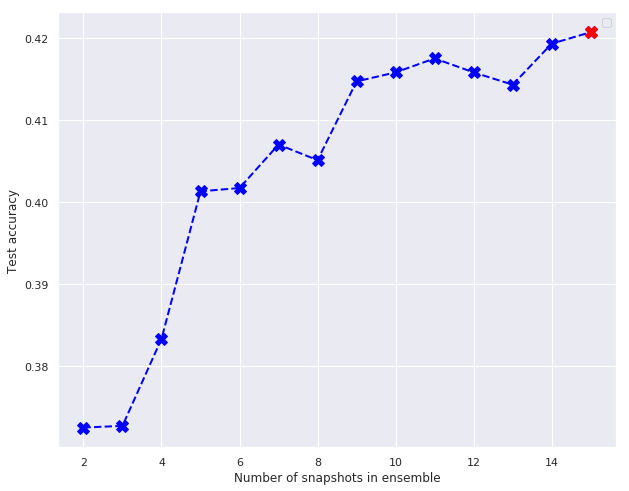

In [124]:
best_net = np.argmax(test_acc)
test_accuracies[best_net]
ensemb_models = [i+1 for i in range(15)]
fig = plt.figure()
sns.set()
# plt.scatter(ensemb_models, ensemble_acc_train_softmx, alpha=0.8, label='3-layer CNN + Shufflenet')
plt.plot(ensemb_models[1:], ensemble_acc_softmx[1:] ,c='blue',marker='X',markersize=12, linewidth=2, linestyle='dashed')
plt.plot(best_net, test_accuracies[best_net], c = "red" ,marker='X',markersize=12)
plt.xlabel("Number of snapshots in ensemble")
plt.ylabel("Test accuracy")
plt.legend(loc='best')
# plt.xlim(1, 15)
# fig.savefig('noisy_ensemble_cifar100.pdf')
plt.show()

In [ ]:
#save logits for training the model:

In [130]:
np.savez('best_ensemble_logits_new_cs', ensemble_logits_training[15])

## Distilling the ensemble models:

In [28]:
teacher_train_logits = np.load(
    'best_ensemble_logits_new_cs.npz')['arr_0']

In [27]:
# Prepare data to train with small model
data = {'X_train': images_train.transpose(0,3,1,2).copy(), 'y_train': np.argmax(labels_train,axis=1),
        'X_val': images_test.transpose(0,3,1,2).copy(), 'y_val': np.argmax(labels_test,axis=1),
       }

In [15]:
train_size = int(0.8 * (images_train.shape[0]))
num_classes, img_size, num_channels = labels_train.shape[1], images_train.shape[1], images_train.shape[-1]

In [29]:
def SoftMax(s):
    # minus max to avoid large s case
    p = np.exp(s-np.expand_dims(np.max(s,axis=1),axis=1))/\
    np.expand_dims(np.exp(s-np.expand_dims(np.max(s,axis=1),axis=1)).sum(axis=1),axis=1)  # matrix of size NxK
    return p

In [33]:
temp = 
[25,30,35,40,45,50]


In [36]:
temp = [t+1 for t in range(15 , 20)]
results = {}
for t in temp:
    num_networks=15
    temp=t
    models_s_15 = teacher_train_logits/temp
    softmax_ensemb_models_15 = np.zeros_like(models_s_15)
    for i in range(num_networks):
           softmax_ensemb_models_15[i] = SoftMax(models_s_15[i])
    average_softmax_15 = np.mean(softmax_ensemb_models_15, axis=0)
    
    net_15 = ThreeLayerConvNet(input_dim=(3, 32, 32),num_classes=100,num_filters=16,filter_size=5,hidden_dim=512,
                        reg=0.001,weight_scale=1,dtype=np.float32)
    small_model_15 = myModel(net_15, data,
                          num_epochs=1, batch_size=100,
                          optimizer='adam',
                          optim_config={
                              'learning_rate': 1e-3,},
                          temperature=temp, soft_target=average_softmax_15, distill_mode='proba',
                          verbose=True, print_every=100)
    tic = time.time()
    small_model_15.train()
    toc = time.time()
    print('Execution time: ',toc-tic)
    val_acc = small_model_15.check_accuracy(data['X_val'],data['y_val'])
    print('Test accuracy: {}'.format(val_acc))
    results[temp] =  val_acc

(Iteration 1 / 500) loss: 592.572072
(Epoch 0 / 1) train acc: 0.009960; val_acc: 0.010000
(Iteration 101 / 500) loss: 589.732794
(Iteration 201 / 500) loss: 589.400423
(Iteration 301 / 500) loss: 589.428814
(Iteration 401 / 500) loss: 589.116374
(Epoch 1 / 1) train acc: 0.253460; val_acc: 0.231000
Execution time:  719.8525304794312
Test accuracy: 0.231
(Iteration 1 / 500) loss: 668.495549
(Epoch 0 / 1) train acc: 0.010480; val_acc: 0.010400
(Iteration 101 / 500) loss: 666.397427
(Iteration 201 / 500) loss: 665.934375
(Iteration 301 / 500) loss: 665.588567
(Iteration 401 / 500) loss: 665.313779
(Epoch 1 / 1) train acc: 0.260460; val_acc: 0.237600
Execution time:  717.1030745506287
Test accuracy: 0.2376
(Iteration 1 / 500) loss: 749.110047
(Epoch 0 / 1) train acc: 0.010400; val_acc: 0.010800
(Iteration 101 / 500) loss: 746.421123
(Iteration 201 / 500) loss: 746.454592
(Iteration 301 / 500) loss: 745.967402
(Iteration 401 / 500) loss: 745.780998
(Epoch 1 / 1) train acc: 0.268340; val_acc:

In [32]:
np.savez('resultst25t50', results)